# HuggingFace tutorial 🤗



By Mathieu Ravaut (NTU-NLP)

Sources:
*   Skim AI's [tutorial on fine-tuning BERT for sentiment analysis](https://skimai.com/fine-tuning-bert-for-sentiment-analysis/)
*   Jay Alammar's [The Illustrated Transformer](https://jalammar.github.io/illustrated-bert/)


## Why HuggingFace?

HuggingFace was created in 2016 by three French men in Brooklyn, with an initial goal of building an AI-powered chatbot talking to depressed teenagers. Later, when BERT was released in late 2018, they pivoted to building the *Github* of machine learning. HuggingFace raised a 15m USD series A in 2018, a 40m USD series B in 2021 (with investors including Richard Socher), and is valued at 440m USD in early 2022. Their ecosystem has become a major part of the NLP and broader deep learning landscape, and is powered by 3 main libraries:
* ***transformers***:  

https://huggingface.co/docs/transformers/index  \
*Purpose* : to easily load (large) pre-trained language models and leverage **transfer learning**  \

Some facts:
1. *transformers* is downloaded on average 2,000,000 times per month
2. 50,000 developers have contributed to it.
3. Fastest ever adoption of an open-source project by the community.

*Paper*: [Transformers: State-of-the-art Natural Language Processing](https://aclanthology.org/2020.emnlp-demos.6/) (Honorable Demonstrations Paper Award at EMNLP 2020)


* ***tokenizers***:

https://huggingface.co/docs/tokenizers/python/latest/ \
*Purpose* : to easily load tokenizers for pre-trained language models

* ***datasets***:

https://huggingface.co/docs/datasets/ \
*Purpose*: to easily load major datasets (e.g., CNN/DailyMail) \
*Paper*: [Datasets: A Community Library for Natural Language Processing](https://aclanthology.org/2021.emnlp-demo.21/) (EMNLP 2021)

---

HuggingFace main platform can be accessed here: \
https://huggingface.co/models

Use it to check whether the model / dataset you want to use is already hosted by HuggingFace.

## Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, roc_curve, auc

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


In [ ]:
## the HuggingFace libraries are not already installed in Colab
!pip install transformers # this will also install tokenizers
!pip install datasets

In [ ]:
import transformers
from transformers import AutoConfig, AutoModel, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
import datasets

## Problem definition

Fine-tuning BERT for sequence classification: add a classifier on top of BERT

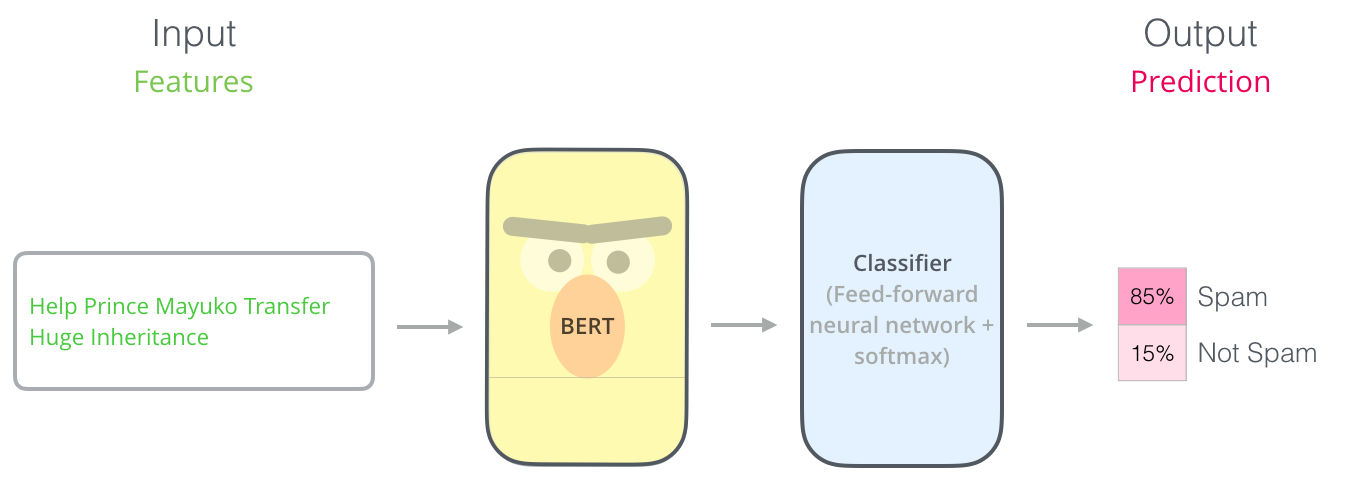

In our case: **classify tweets about airlines as positive (label: 1) /negative (label: 0)**.

## Data

In [ ]:
# The datasets library enables to load a dataset by just calling datasets.load_data("dataset_name")
data = datasets.load_dataset("tasosk/airlines")

Using custom data configuration tasosk--airlines-36f1e43ef1501ec6


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.17M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/382k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/tasosk--airlines-36f1e43ef1501ec6/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# since we did not specify a split, all 3 splits train/validation/test have been loaded
data

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 3239
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 240
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 562
    })
})

In [ ]:
data["train"]

Dataset({
    features: ['text', 'labels'],
    num_rows: 3239
})

In [ ]:
data["train"]["text"][0]

"  I bought a ticket Padang - Kuala Lumpur in february 2017 for a flight in August. With this flight we had 6 hours in Kuala Lumpur to catch the other flight. After a month I a got a message of a reschedule for about two hours later. It still should be enough for the transfer in Kuala Lumpur. On the day of departure when we arrived at the ariport a next reschedule of the flight. This means about two hours for transer. This is very tight for a transer in Kuala Lumpur, due to the two different terminals. We informed the AirAsia staff, they arranged a Priority luggage handling. The man took a picture of our passport and ticket and send it to Kuala Lumpur to inform the office there and probably inform the Oman Air counter, our connecting carrier. Finally, at the gate we waited for three hours to found out that the flight was delayd for almost an hour! The plane had a fast and smooth trip to Kuala Lumpur. At arrival we ran to the luggage band, picked up our luggage as first and run to the n

In [ ]:
data["train"]["labels"][0]

0

In [ ]:
# classes
np.unique(data["train"]["labels"])

array([0, 1])

In [ ]:
# % positives in train/validation/test
pos_frac_train = 100 * np.mean([data["train"]["labels"][i] for i in range(len(data["train"]["labels"]))])
pos_frac_val = 100 * np.mean([data["validation"]["labels"][i] for i in range(len(data["validation"]["labels"]))])
pos_frac_test = 100 * np.mean([data["test"]["labels"][i] for i in range(len(data["test"]["labels"]))])
pos_frac_train, pos_frac_val, pos_frac_test

(42.88360605125038, 46.619217081850536, 45.0)

## Dataset class

In [ ]:
class AirlinesDataset():

    def __init__(self, tokenizer, tweets, labels, max_length):
        super(AirlinesDataset, self).__init__()

        self.tokenizer = tokenizer
        self.tweets = tweets
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = self.tweets[item]
        label = self.labels[item]

        inputs = self.tokenizer(
            tweet,
            padding = "max_length",
            max_length=self.max_length,
            return_tensors = "pt"
        )
        inputs["input_ids"] = inputs["input_ids"][:, :self.max_length]
        inputs["attention_mask"] = inputs["attention_mask"][:, :self.max_length]
        # inputs["input_ids"] has (1, max_length)

        label = torch.tensor(label).float()

        return {
            "input_ids": inputs["input_ids"][0],
            "attention_mask": inputs["attention_mask"][0],
            "labels": label,
        }

## Model class

In [ ]:
class FinetuneModel(nn.Module):
    """Pretrained Model + classifier
    """
    def __init__(self, pretrained_model, d_in, d_h, d_out, freeze_pretrained=False):
        super(FinetuneModel, self).__init__()

        # Instantiate BERT model
        self.pretrained_model = pretrained_model

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(d_in, d_h),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(d_h, d_out)
        )

        # Freeze the encoder model
        if freeze_pretrained:
            for param in self.pretrained_model.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input to pretrained model
        outputs = self.pretrained_model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )
        #print(outputs.keys()) # ["last_hidden_state", "pooler_output", "hidden_states"]

        # Extract the last hidden state
        last_hidden = outputs["last_hidden_state"] # (batch_size, sequence_length, d_in)

        # Use the `[CLS]` token of the last hidden state for classification task
        last_hidden_state_cls = last_hidden[:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

## Putting data, datasets, loaders and models together

3 classes make it simple to load and access a pre-trained language model hosted on HuggingFace's platform:

*   **AutoConfig**: load the model configuration (dictionary of parameters) given its name
*   **AutoModel**: load the model given its name
*   **AutoTokenizer**: load the associated tokenizer given the model name

In [ ]:
# Hyper-parameters
pretrained_model_name = "bert-base-cased" # we can change this, and play with any model from HuggingFace!
# BERT-base: "bert-base-cased"
# BERT-large: "bert-large-cased"
# RoBERTa-base: "roberta-base"
# RoBERTa-large: "roberta-large"
# etc ...
max_length = 256
batch_size = 16
d_in = 768 # bert-base / roberta-base
d_h = 512 # 512
d_out = 1 # 2 classes so 1 is enough
freeze_pretrained = True

In [ ]:
# tokenizer -> automatically detects which model it is and loads the appropriate tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name) # remember AutoTokenizer

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [ ]:
# Example of an invalid model name -> this will cause an Error
# other_tokenizer = AutoTokenizer.from_pretrained("bert")

In [ ]:
# datasets
train_dataset = AirlinesDataset(tokenizer, data["train"]["text"], data["train"]["labels"], max_length)
val_dataset = AirlinesDataset(tokenizer, data["validation"]["text"], data["validation"]["labels"], max_length)
test_dataset = AirlinesDataset(tokenizer, data["test"]["text"], data["test"]["labels"], max_length)

In [ ]:
# data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
# Check the 1st batch shape
for batch in train_loader:
  print(batch["input_ids"].shape, batch["attention_mask"].shape, batch["labels"].shape)
  break

torch.Size([16, 256]) torch.Size([16, 256]) torch.Size([16])


In [ ]:
# config
config = AutoConfig.from_pretrained(
    pretrained_model_name,
    output_hidden_states = True
    ## multiple config choices can be set here
    # cache_dir = cache_dir
)
# remember AutoConfig
config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [ ]:
# Build the pre-trained model encoder
pretrained_model = AutoModel.from_pretrained(pretrained_model_name, config = config) # remember AutoModel
n_params = sum(p.numel() for p in pretrained_model.parameters() if p.requires_grad)
print("\nThe pre-trained model has {} trainable parameters".format(n_params))

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



The pre-trained model has 108310272 trainable parameters


In [ ]:
# Check the pre-trained model parameters
for name, p in pretrained_model.named_parameters():
    print(name, p.shape)

In [ ]:
# How to access weights of a specific layer
print(pretrained_model.encoder.layer[0].attention.output.dense.weight.shape)
print(pretrained_model.encoder.layer[0].attention.output.dense.weight)

torch.Size([768, 768])
Parameter containing:
tensor([[-0.0120,  0.0076,  0.0167,  ...,  0.0348, -0.0040,  0.0132],
        [ 0.0065,  0.0274,  0.0284,  ...,  0.0059,  0.0220, -0.0446],
        [ 0.0097, -0.0445, -0.0100,  ..., -0.0073, -0.0080, -0.0339],
        ...,
        [-0.0110, -0.0138, -0.0282,  ..., -0.0293,  0.0252,  0.0364],
        [ 0.0014, -0.0286,  0.0006,  ..., -0.0360, -0.0118,  0.0236],
        [ 0.0091, -0.0089, -0.0206,  ..., -0.0086, -0.0253, -0.0128]],
       requires_grad=True)


In [ ]:
# Build our custom model: a pre-trained encoder wrapped with a 2-layers classifier on top
model = FinetuneModel(pretrained_model, d_in, d_h, d_out, freeze_pretrained)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nThe model has {} trainable parameters".format(n_params)) # will be small if we froze the pre-trained encoder weights!
model = model.to(device)


The model has 394241 trainable parameters


## Optimization

In [ ]:
# Hyper-parameters
n_epochs = 5
lr = 1e-4
warmup = 0.1

In [ ]:
# loss function
loss_fct = nn.BCEWithLogitsLoss()

In [ ]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

In [ ]:
# scheduler
total_steps = int(n_epochs * (len(data["train"]["text"]) / batch_size))
warmup_steps = int(warmup * total_steps)
print("Total # training steps: {}, # warmup steps: {}".format(total_steps, warmup_steps))
# This scheduler is not available in PyTorch, but it is in HuggingFace => it is super important to use it with Transformer-based models
# Same with the AdamW optimizer: not in PyTorch, but import it from HuggingFace instead
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = warmup_steps,
    num_training_steps = total_steps
)
# this will linearly increase the learning rate from 0 to lr for warmup_steps, then linearly decrease it to 0 for the remaining steps

Total # training steps: 1012, # warmup steps: 101


## Training loop

In [ ]:
def train(train_loader, model, loss_fct, optimizer, scheduler):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader):
        model.zero_grad()
        optimizer.zero_grad()

        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outs = model(input_ids, attention_mask) # forward pass (batch_size, 1)
        outs = outs[:,0] # (batch_size)

        loss = loss_fct(outs, labels)
        train_losses.append(loss.item())

        loss.backward() # backward pass
        optimizer.step() # weights update
        scheduler.step() # lr update
    train_loss = np.mean(train_losses)

    return train_loss

In [ ]:
def eval(loader, model, loss_fct):
    model.eval()
    val_losses = []
    val_probs = []
    sigmoid = nn.Sigmoid()
    val_labels = []
    for batch in tqdm(loader):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        val_labels += list(labels.detach().cpu().numpy())

        with torch.no_grad():
            outs = model(input_ids, attention_mask)
        outs = outs[:,0]
        probs = sigmoid(outs)
        val_probs += list(probs.detach().cpu().numpy())

        loss = loss_fct(outs, labels)
        val_losses.append(loss.item())
    val_loss = np.mean(val_losses)
    val_probs = np.array(val_probs)
    val_labels = np.array(val_labels)
    fpr, tpr, threshold = roc_curve(val_labels, val_probs)
    val_auc = 100 * auc(fpr, tpr)

    return val_loss, val_auc, val_probs, val_labels

In [ ]:
# epoch 0 evaluation
val_loss, val_auc, _, _ = eval(val_loader, model, loss_fct)
print("\nPre-training val loss: {:.4f}, AUC: {:.4f}".format(val_loss, val_auc))
for epoch in range(1, n_epochs + 1):
    print("\nNew epoch, epoch {} / {}".format(epoch, n_epochs))

    # Training round
    train_loss = train(train_loader, model, loss_fct, optimizer, scheduler)

    # Validation round
    val_loss, val_auc, _, _ = eval(val_loader, model, loss_fct)

    print("Mean train loss: {:.4f}, val loss: {:.4f}, val AUC: {:.4f}".format(train_loss, val_loss, val_auc))

  0%|          | 0/36 [00:00<?, ?it/s]


Pre-training val loss: 0.6964, AUC: 36.1667

New epoch, epoch 1 / 5


  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Mean train loss: 0.6152, val loss: 0.4919, val AUC: 88.6756

New epoch, epoch 2 / 5


  0%|          | 0/203 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# Best val AUCs:
# bert-base-cased frozen: 93.38
# bert-base-cased unfreeze BERT weights: 97.12
# roberta-base frozen: 94.65

## Test

In [ ]:
test_loss, test_auc, test_probs, test_labels = eval(test_loader, model, loss_fct)
print("Test loss: {:.4f}, test AUC: {:.4f}".format(test_loss, test_auc))

  0%|          | 0/15 [00:00<?, ?it/s]

Test loss: 0.4335, test AUC: 92.3611


In [ ]:
n_check = 20
for i in range(n_check):
    tweet = data["test"]["text"][i]
    test_label = test_labels[i]
    prob = test_probs[i]
    print("\n", "*"*20, "Tweet {}:".format(i+1))
    print(tweet)
    print("*"*10, "Label: {}".format(test_label))
    print("*"*10, "Model prediction: {:.4f}".format(prob))


 ******************** Tweet 1:
 Newark to Palma via Düsseldorf. I have flown Eurowings many times and I honestly don't get all the hate they get from others. It's a low-cost airline that gets you from A to B and charges you for almost everything as many other low costs do. It is not the cheapest option out there but it does give good flying hours. I've been delayed with them a few times but they always sent emails giving information even if the delay was 10minutes. On the flight from Newark to Düsseldorf, the flight was late out due to ATC capacity which is a normal issue. The service was standard, we had to pay for meals and drinks which we knew about since it is shown in your booking that they are not included. The seats were also pretty comfortable and the cabin crew were nice. On the short haul flight to Palma also the same. I have no complaints against them and I do think they are trying hard to be better but some passengers just like to rate them 1/10 because they didn't get a f

## Generation

So far, we have used pre-trained language models to have access to their distributed representations, and use them to train a classifier. But what about the case where we want to use a pre-trained **encoder-decoder** model?

In that case, at **training time**, when we call the .forward() function of the model, we need to pass in labels so that the model can do **teacher forcing**:

outputs = model(\
  input_ids = input_ids, \
  attention_mask = attention_mask,\
  labels = labels
)

However, at inference time, we do not have labels. The function to use is **generate()**, which will perform **auto-regressive decoding**, and supports the main decoding algorithms: greedy decoding, beam search, diverse beam search, etc.

output_ids = model.generate(\
  input_ids = input_ids,
  attention_mask = attention_mask\
  num_beams = 5, # 1 will be equivalent to greedy search \
  num_return_sequences = 1,\
  max_length = 64,\
  repetition_penalty = 1.0,\
  length_penalty = 1.0,\
  no_repeat_ngram_size = 3.0\
)

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

In [ ]:
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

In [ ]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
inputs

{'input_ids': tensor([[    0, 31414,     6,   127,  2335,    16, 11962,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
outputs = model.generate(
    input_ids = inputs["input_ids"],
    attention_mask = inputs["attention_mask"]
)
outputs

tensor([[    2,     0, 31414,     6,   127,  2335,    16, 11962,     2]])

In [ ]:
decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens = True)
decoded_outputs

['Hello, my dog is cute']